In [1]:
import tensorflow.keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf

# Global Constant

IMG_HEIGHT = 512
IMG_WIDTH = 512
CHANNELS = 3

# Function to get content and style layers of content, style, generated image
def get_layers(content_image, style_image, generated_image):

    input_tensor = K.concatenate([content_image, style_image, generated_image], axis=0)
    input_tensor = tf.keras.applications.vgg16.preprocess_input(input_tensor)

    vgg19 = tf.keras.applications.VGG16(
        input_tensor=input_tensor,
        include_top=False,
        weights='imagenet')
    vgg19.trainable = False

    content_layer_name = 'block5_conv2'
    style_layer_names = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1',
                        'block4_conv1',
                        'block5_conv1']

    layers = {layer.name : layer.output for layer in vgg19.layers}

    content_layer = layers[content_layer_name]
    style_layers = [layers[layer] for layer in style_layer_names]

    return content_layer, style_layers


# Content loss (So that generated image contains the outline of content image)
def content_loss(content_features, generated_features):

    return 0.5 * K.sum(K.square(content_features - generated_features))

# Variation loss (To reduce noise)
def variation_loss(generated_matrix):

    a = K.square(generated_matrix[:, :IMG_WIDTH-1, :IMG_WIDTH-1, :] - generated_matrix[:, 1:, :IMG_HEIGHT-1, :])
    b = K.square(generated_matrix[:, :IMG_WIDTH-1, :IMG_WIDTH-1, :] - generated_matrix[:, :IMG_HEIGHT-1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

# Gram matrix
def gram_matrix(features):

    return K.dot(features, K.transpose(features))

# Style loss (So that generated image contains style of style image)
def style_loss(style_layer, generated_style_layer):

    img_channels, img_size = CHANNELS, IMG_HEIGHT * IMG_WIDTH

    style_features = K.batch_flatten(K.permute_dimensions(style_layer, (2, 0, 1)))
    generated_features = K.batch_flatten(K.permute_dimensions(generated_style_layer, (2, 0, 1)))

    style_gram_matrix = gram_matrix(style_features)
    generated_gram_matrix = gram_matrix(generated_features)

    return K.sum(K.square(style_gram_matrix - generated_gram_matrix)) / (4.0 * (img_channels ** 2) * (img_size ** 2))

# Computing total loss
def total_loss(content_layer, style_layers, generated_image, content_weight=0.1, style_weight=100, variation_weight=1):

    orig_content_layer, gen_content_layer = content_layer[0, :, :, :], content_layer[2, :, :, :]

    total_content_loss = content_loss(orig_content_layer, gen_content_layer)

    total_variation_loss =  variation_loss(generated_image)

    total_style_loss = 0

    for layer in style_layers:
        total_style_loss += style_loss(layer[1, :, :, :], layer[2, :, :, :])

    total_style_loss *= 1 / len(style_layers)

    return content_weight * total_content_loss + style_weight * total_style_loss + variation_weight * total_variation_loss

# This function returns preocessed content and style Image
def get_data(content_path, style_path):

    content_image = plt.imread(content_path)
    content_image = np.array(cv2.resize(content_image, (512, 512)), dtype='float32')

    style_image = plt.imread(style_path)
    style_image = np.array(cv2.resize(style_image, (512, 512)), dtype='float32')

    style_image = np.expand_dims(style_image, axis=0)
    style_image = style_image[:, :, :, :3]

    content_image = np.expand_dims(content_image, axis=0)
    content_image = content_image[:, :, :, :3]

    content_image = content_image[:, :, :, ::-1]
    style_image = style_image[:, :, :, ::-1]

    return content_image, style_image

In [11]:
content_image, style_image = get_data("/content/content_img2.jpg", "/content/style_img2.jpg")

content_image_copy = content_image.copy()

In [4]:
import time
import IPython.display as display

In [5]:
# Evaluator class for optimizing
class Evaluator:

    def loss(self, x):

        loss_value, grad_values = loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values

        return self.loss_value

    def grads(self, x):

        grad_values = np.copy(self.grad_values)
        return grad_values

# This returns loss and gradients
def loss_and_grads(generated):

    generated = generated.reshape((1, 512, 512, 3))
    outs = f_outputs([generated])
    loss_value = outs[0]
    grad_values = np.array(outs[1]).flatten().astype('float64')
    return loss_value, grad_values

In [12]:
# Disabling eager exceution to use K.Gradients function
tf.compat.v1.disable_eager_execution()

# Creating variables and constant in the computational flow graph
content_image = K.constant(content_image)
style_image = K.constant(style_image)
generated_image = K.placeholder((1, 512, 512, 3))
loss = K.variable(0.)

# Get the layers needed to prepare the loss metric
content_layer, style_layers = get_layers(content_image, style_image, generated_image)

# Define loss and gradient
loss = total_loss(content_layer, style_layers, generated_image)

# Define a function to get loss and gradients
f_outputs = K.function([generated_image], [loss, K.gradients(loss, generated_image)])

In [22]:
# Creating evaluator object
evaluator = Evaluator()

# Assigning content image to generated image
generated_img = content_image_copy

for i in range(11):
    print('In iteration no:', i)

    start_time = time.time()
    generated_img, min_val, info = fmin_l_bfgs_b(evaluator.loss, generated_img.flatten(),
                                                     fprime=evaluator.grads, maxfun=300)

    if i % 5 == 0:
        generated_image = generated_img.copy()
        generated_image = generated_image.reshape(512, 512, 3)
        generated_image = np.clip(generated_image, 0, 255).astype('uint8')
        cv2.imwrite("result " + str(i) + ".jpg", generated_image)

    end_time = time.time()
    display.clear_output(wait=True)

    print(f'Loss: {round(min_val / 10**6, 3)} x 10^6')

    print(f'Iteration {i} took {end_time - start_time} seconds')

Loss: 843.539 x 10^6
Iteration 10 took 103.75590562820435 seconds


In [32]:
from google.colab.patches import cv2_imshow as show

# content image

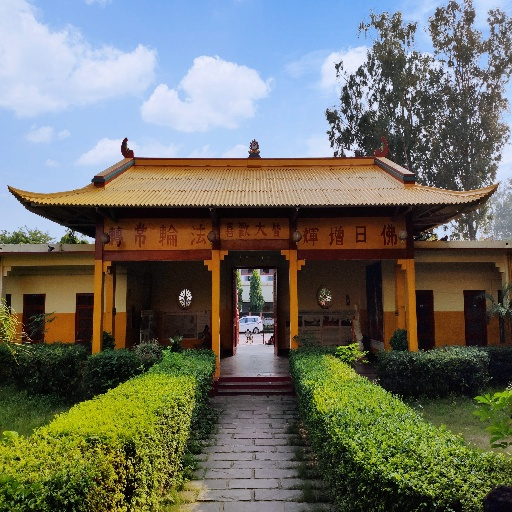

In [48]:
from IPython.display import Image, display
display(Image(filename="/content/content_img2.jpg"))

# style image

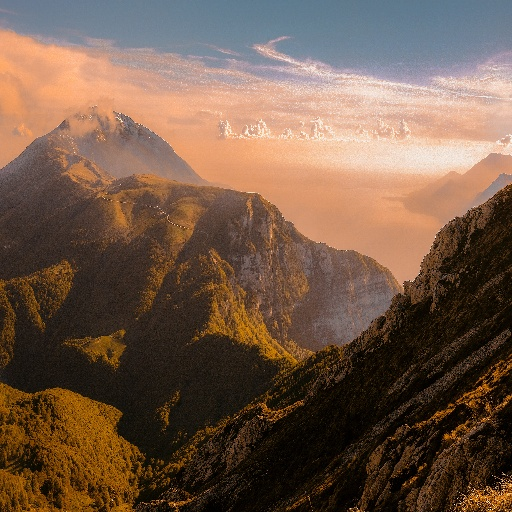

In [49]:
display(Image(filename="/content/style_img2.jpg"))

# Generated image

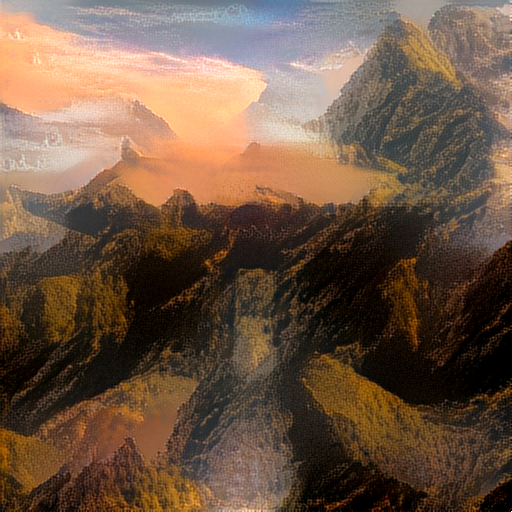

In [34]:
generated_image = generated_img.copy()
generated_image = generated_image.reshape(512, 512, 3)
generated_image = np.clip(generated_image, 0, 255).astype('uint8')
show(generated_image)